### Here we train our model using Google's stock data points from 2012-01-01 to 2023-03-25

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [2]:
# Set dates we will extract data of stock from
start = "2012-01-01"
end = "2023-03-25"

# Set ticker of stock
tick = 'GOOG'

# Download data
data = yf.download(tick, start, end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,16.262545,16.641375,16.248346,16.573130,16.573130,147611217
2012-01-04,16.563665,16.693678,16.453827,16.644611,16.644611,114989399
2012-01-05,16.491436,16.537264,16.344486,16.413727,16.413727,131808205
2012-01-06,16.417213,16.438385,16.184088,16.189817,16.189817,108119746
2012-01-09,16.102144,16.114599,15.472754,15.503389,15.503389,233776981
...,...,...,...,...,...,...
2024-03-19,148.979996,149.619995,147.009995,147.919998,147.919998,17748400
2024-03-20,148.789993,149.759995,147.664993,149.679993,149.679993,17730000
2024-03-21,150.320007,151.304993,148.009995,148.740005,148.740005,19843900


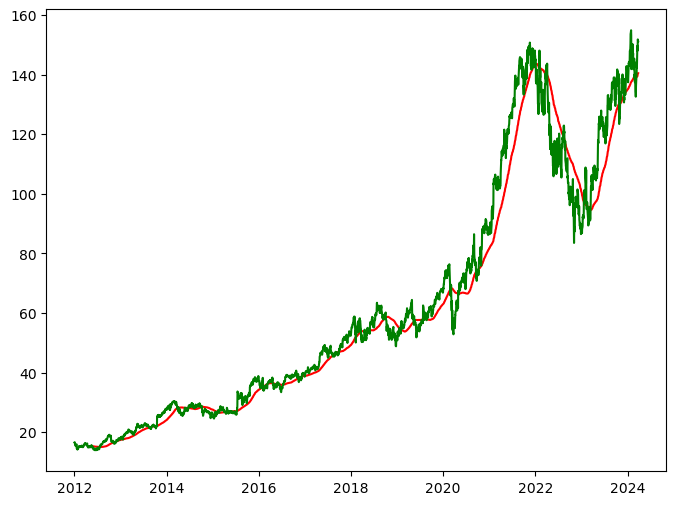

In [4]:
# Get moving average of close price for 100 days
ma_100_days = data.Close.rolling(100).mean()

# Plot data
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(data.Close, 'g')
plt.show()

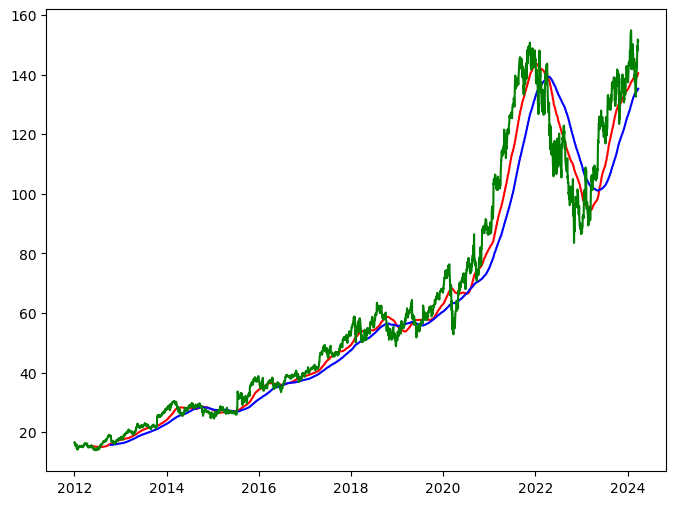

In [5]:
# Get moving average of close price for 200 days
ma_200_days = data.Close.rolling(200).mean()

# Plot data
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(ma_200_days, 'b')
plt.plot(data.Close, 'g')
plt.show()

In [6]:
# Remove null data points to clean data
data.dropna(inplace=True)

# Initialize 80% of data points for training data set
# 20% of data points for testing data set
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.8)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.8): len(data)])


data_test.shape[0]+data_train.shape[0]



3076

In [7]:
# Scale data to fit in between range 0, 1
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train) # Apply scale

In [8]:
# Create training data set
x = []
y = []

# Iterate starting from 100 since our LSTM model is going to use 
#  100 previous time steps as input
for i in range(100, data_train_scale.shape[0]): 
    x.append(data_train_scale[i-100:i]) # Appending scaled prev 100 data pts
    y.append(data_train_scale[i,0]) # Appending next scaled data pt

# Convert data set to np arrays
x, y = np.array(x), np.array(y)    
    
# Create model based off training data set
model = Sequential() # Init sequential model

# We will use four LSTM layers
# Add LSTM layer with 50 neurons, ReLu activation, returning full sequence of outputs
model.add(LSTM(units = 50, activation = 'relu', return_sequences =  True,
    input_shape = ((x.shape[1],1)))) 
model.add(Dropout(0.2)) # Add dropout layer with 0.2 rate to reduce overfitting

# Layer with 60 neurons, ReLu activation, returning full sequence of output
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3)) # Reduce overfitting

# Layer with 80 neurons, ReLu activation, returning full sequence of output
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4)) # Reduce overfitting

# Layer with 120 neurons, ReLu activation
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5)) # Reduce overfitting

# Add Dense layer to produce output as single unit
model.add(Dense(units = 1))

/Users/aj/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Compile network using Adam optimizer and mean squared error loss function
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [10]:
# Train data passing through data set 50 times, 32 samples at a time, while displaying in console
model.fit(x,y, epochs = 50, batch_size = 32, verbose = 1)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0482
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0046
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0036
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0029
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0035
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0023
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0031
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0032
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0022
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0021
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0025
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0026
Epoch 13/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0022
Epoch 14/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 0.0021
Epoch 15/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0022
Epoc

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,285 (2.05 MB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 357,524 (1.36 MB)

In [12]:
# Select 100 most recent days from training set
past_100_days = data_train.tail(100)

# Concat last 100 days of training set with testing set
data_test = pd.concat([past_100_days, data_test], ignore_index=True)
data_test_scale = scaler.transform(data_test) # Scale

# Initialize empty lists
x = []
y = []


for i in range(100, data_test_scale.shape[0]): 
    x.append(data_test_scale[i-100:i]) # Appending scaled prev 100 data pts
    y.append(data_test_scale[i,0]) # Appending next scaled data pt

# Convert lists to np arrays in order to use for model prediction
x, y = np.array(x), np.array(y)    
y_predict = model.predict(x) # Use trained model to predict output values

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


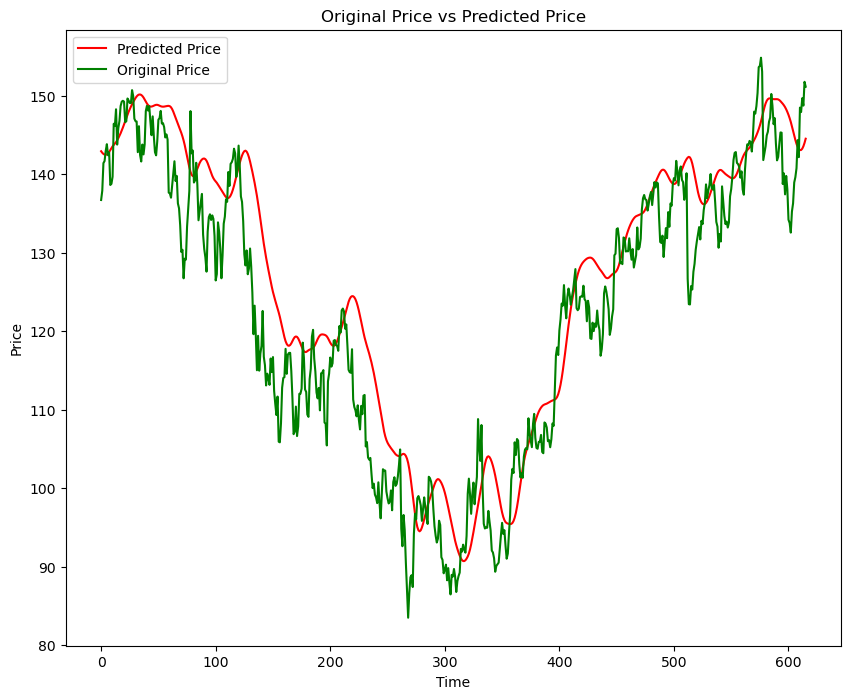

In [13]:
# Prepare predictions and actual values for inverse scaling
# Reshape data to the original shape expected by the scaler
y_predict_rescaled = scaler.inverse_transform(y_predict.reshape(-1, 1))
y_rescaled = scaler.inverse_transform(y.reshape(-1, 1))

# Plot predicted price vs original price for comparison
plt.figure(figsize=(10,8))
plt.plot(y_predict_rescaled, 'r', label = 'Predicted Price')
plt.plot(y_rescaled, 'g', label = 'Original Price')
plt.title('Original Price vs Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


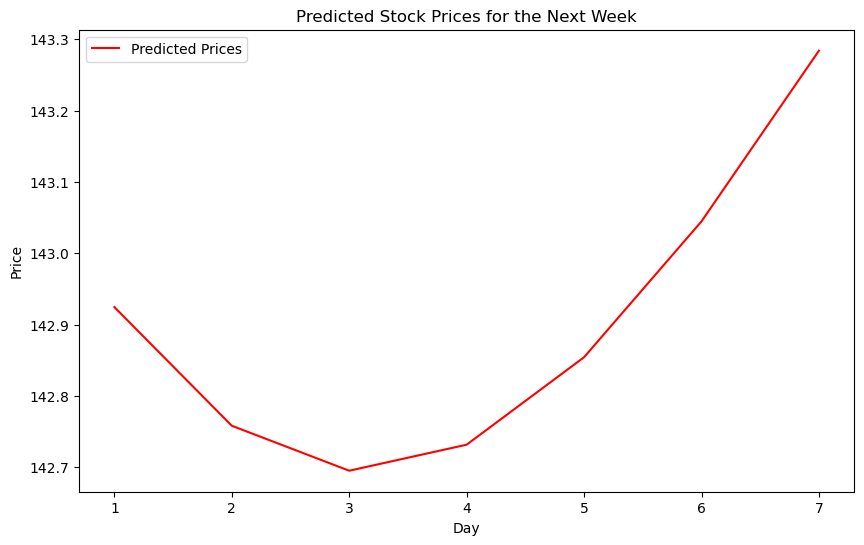

In [14]:
# Select the last 100 days from your dataset
last_100_days = data_train_scale[-100:]  # Keep it in the original format for slicing

# Initialize list to store the predictions
predicted_prices = []

# Predict next 7 days
for _ in range(7):
    # Reshape last_100_days to fit model input shape
    x_test = np.array([last_100_days])
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    # Predict next day's price
    predicted_price = model.predict(x_test)
    
    # Inverse scaling the prediction
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)
    
    # Append the predicted price to predicted_prices
    predicted_prices.append(predicted_price_unscaled[0][0])
    
    # Update last_100_days for the next prediction
    # Use the scaled predicted price for updating the sequence
    last_100_days = np.append(last_100_days, predicted_price)[1:].reshape(-100, 1)  # Ensure it's reshaped back to (-100, 1)

# Plotting the predicted prices
plt.figure(figsize=(10,6))
days = range(1, 8)
plt.plot(days, predicted_prices, 'r', label='Predicted Prices')
plt.title('Predicted Stock Prices for the Next Week')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()


In [15]:
# Save model
model.save('Stock Prediction Model.keras')